In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import joblib
import xgboost as xgb

(CVXPY) Dec 17 10:13:02 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: 找不到指定的模块。')


In [2]:
data = pd.read_csv('factor_pass.csv', index_col=0)
data.fillna(0, inplace=True)

In [3]:
data

,id,name,date,evebit,dividendyield,day_momentum,val_ortoev_ttm,val_lnmv,val_lntotassets,fa_sellexpensetogr_ttm,...,fa_operincometopbt,fa_octogr_ttm,fa_netprofitmargin_ttm,fa_salescashtoor,fa_cashrecovratio_ttm,fa_blev,fa_current,fa_apturn_ttm,fa_ncgr_ttm,return
0,338,潍柴动力,2016-01-04,12.680916,3.893215,0.000000,2.537171,24.305300,25.5089,8.1856,...,0.8770,95.4396,3.7767,1.0049,10.429103,0.7290,1.3775,2.4120,-37.4817,-0.012236
1,338,潍柴动力,2016-01-05,12.680916,3.941441,0.000000,2.563779,24.292999,25.5089,8.1856,...,0.8770,95.4396,3.7767,1.0049,10.429103,0.7290,1.3775,2.4120,-37.4817,0.036036
2,338,潍柴动力,2016-01-06,12.680916,3.804348,0.000000,2.493336,24.328400,25.5089,8.1856,...,0.8770,95.4396,3.7767,1.0049,10.429103,0.7290,1.3775,2.4120,-37.4817,-0.088043
3,338,潍柴动力,2016-01-07,12.680916,4.171633,0.000000,2.711453,24.236300,25.5089,8.1856,...,0.8770,95.4396,3.7767,1.0049,10.429103,0.7290,1.3775,2.4120,-37.4817,0.030989
4,338,潍柴动力,2016-01-08,12.680916,4.046243,0.000000,2.643240,24.266800,25.5089,8.1856,...,0.8770,95.4396,3.7767,1.0049,10.429103,0.7290,1.3775,2.4120,-37.4817,-0.036994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16974,601689,拓普集团,2022-12-26,66.745010,0.746774,0.985613,0.207402,24.947599,23.9587,1.4537,...,0.9554,89.6781,9.5286,1.0952,7.318087,0.2216,1.2370,2.1767,-76.6964,-0.001290
16975,601689,拓普集团,2022-12-27,66.745010,0.747739,0.986239,0.207659,24.946301,23.9587,1.4537,...,0.9554,89.6781,9.5286,1.0952,7.318087,0.2216,1.2370,2.1767,-76.6964,-0.059916
16976,601689,拓普集团,2022-12-28,66.745010,0.795396,0.934050,0.220349,24.884501,23.9587,1.4537,...,0.9554,89.6781,9.5286,1.0952,7.318087,0.2216,1.2370,2.1767,-76.6964,0.006356
16977,601689,拓普集团,2022-12-29,66.745010,0.790372,0.947643,0.219014,24.890800,23.9587,1.4537,...,0.9554,89.6781,9.5286,1.0952,7.318087,0.2216,1.2370,2.1767,-76.6964,0.000000


In [4]:
returns = data.pivot_table(index='date', columns='id', values='return')

In [5]:
returns.fillna(0, inplace=True)

In [6]:
returns

id,338,625,951,2594,600104,600418,600660,601238,601633,601689
date,,,,,,,,,,
2016-01-04,-0.012236,0.011688,0.017576,0.010041,0.010644,0.010355,-0.002776,0.038821,0.022789,-0.057040
2016-01-05,0.036036,0.037227,0.020846,0.018029,0.012036,0.010981,0.025052,0.051561,0.017825,0.026227
2016-01-06,-0.088043,-0.078589,-0.093932,-0.082920,-0.059465,-0.096307,-0.059063,-0.080972,-0.080560,-0.100165
2016-01-07,0.030989,0.051041,0.028332,0.072550,0.027924,0.027244,0.054834,0.079295,0.016190,-0.027485
2016-01-08,-0.036994,-0.072843,-0.058234,-0.026081,-0.026140,-0.094384,-0.033516,-0.064399,-0.068416,-0.099859
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.007775,0.002297,-0.004032,-0.001143,0.003399,0.020573,0.006803,0.002641,0.005657,-0.001290
2022-12-27,-0.021215,-0.055768,-0.028340,-0.028613,-0.008808,-0.043197,-0.013795,-0.021071,-0.033091,-0.059916
2022-12-28,-0.001970,-0.005663,0.046528,0.000550,-0.020506,-0.012039,-0.000285,-0.017040,0.002738,0.006356


In [24]:
def cal_turnover(weights):
    return np.sum(np.abs(weights[:-1] - weights[1:]), axis=1)

# Mean Variance Framework

In [8]:
def cal_covariance_matrix(returns, pre_day, lambda_value = 0.94):
    """
    param:
        returns: a dataframe of returns
        pre_day: the predict day
        lambda_value: the weight of exponential decay
    return: a covariance matrix
    """
    returns = returns.loc[returns.index < pre_day, :].values
    mean_returns = np.mean(returns, axis=1)
    returns = returns - mean_returns.reshape(-1, 1)

    n = len(returns)
    weights = np.power(lambda_value, np.arange(n)[::-1])
    weighted_returns = returns * weights.reshape(-1, 1)
    exp_cov_matrix = weighted_returns.T @ returns / np.sum(weights)
    
    return exp_cov_matrix

In [9]:
def mpt_optimization(cov_matrix, expected_return, risk_aversion):
    """
    param:
        cov_matrix: a covariance matrix
        expected_return: a vector of expected returns
        risk_aversion: a risk aversion coefficient
    return: a vector of optimal weights
    """
    num_assets = len(expected_return)
    weights = cp.Variable(num_assets)
    objective = cp.Maximize(expected_return @ weights - 1/2 * risk_aversion * cp.quad_form(weights, cov_matrix))
    constraints = [cp.sum(weights) == 1, weights >= 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    optimal_weights = weights.value
    
    return optimal_weights

In [10]:
xgb_model = joblib.load("XGBoost.pkl")

In [11]:
lgb_model = joblib.load("lightGBM.pkl")

In [12]:
data['continuous_count'] = data.groupby((data['evebit'] != data['evebit'].shift(1)).cumsum()).cumcount() + 1
data = data.reindex(columns=data.columns.tolist()[:-2] + ['continuous_count', 'return'])
data.dropna(inplace=True)
date_list = data.loc[data.loc[:, "date"] >= "2022-01-01", "date"].unique()
y_outsample_test = returns[returns.index >= "2022-01-01"].values
# preds = xgb_model.predict(xgb.DMatrix(data.loc[data.loc[:, "date"] == date_list[0]].drop(columns=["date", "id", "name", "return"])))

In [13]:
outsample_return_equal = np.multiply(y_outsample_test, (np.ones(len(date_list)) / returns.shape[1]).reshape(-1, 1)).sum(axis=1)

In [14]:
def MPT_xgb(risk_aversion):
    weights_list = []
    for i in date_list:
        preds1 = xgb_model.predict(xgb.DMatrix(data.loc[data.loc[:, "date"] == i].drop(columns=["date", "id", "name", "return"])))
        # preds2 = lgb_model.predict(data.loc[data.loc[:, "date"] == i].drop(columns=["date", "id", "name", "return"]))
        weights_list.append(mpt_optimization(cal_covariance_matrix(returns, i), preds1, risk_aversion))
    result = np.stack(weights_list, axis=0)
    return np.multiply(y_outsample_test, result).sum(axis=1), cal_turnover(result).mean()

def MPT_lgb(risk_aversion):
    weights_list = []
    for i in date_list:
        # preds1 = xgb_model.predict(xgb.DMatrix(data.loc[data.loc[:, "date"] == i].drop(columns=["date", "id", "name", "return"])))
        preds2 = lgb_model.predict(data.loc[data.loc[:, "date"] == i].drop(columns=["date", "id", "name", "return"]))
        weights_list.append(mpt_optimization(cal_covariance_matrix(returns, i), preds2, risk_aversion))
    result = np.stack(weights_list, axis=0)
    return np.multiply(y_outsample_test, result).sum(axis=1), cal_turnover(result).mean()

# Black-Litterman

In [15]:
cap = pd.read_csv("TRD_Dalyr.csv")

In [16]:
grouped_cap = cap.pivot_table(index='Trddt', columns='Stkcd', values='Dsmvtll')

In [17]:
grouped_cap

Stkcd,338,625,951,2594,600104,600418,600660,601238,601633,601689
Trddt,,,,,,,,,,
2022-01-04,1.200004e+08,9.802465e+07,19596820.92,4.913617e+08,2.417308e+08,36691364.49,93940058.97,1.111157e+08,2.931864e+08,56534989.14
2022-01-05,1.211536e+08,9.624122e+07,18985888.86,4.591966e+08,2.447685e+08,34026872.54,94340656.24,1.092977e+08,2.821412e+08,55543147.23
2022-01-06,1.215606e+08,9.280176e+07,19303103.58,4.533220e+08,2.407961e+08,34179753.23,92217490.73,1.066071e+08,2.737347e+08,55014164.87
2022-01-07,1.204753e+08,9.216482e+07,20231250.38,4.469397e+08,2.413803e+08,33611910.68,94080268.01,1.057345e+08,2.771709e+08,53989261.56
2022-01-10,1.225103e+08,9.241960e+07,20430978.17,4.465771e+08,2.424318e+08,32847507.26,96744239.84,1.063162e+08,2.877865e+08,57460708.26
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,6.980239e+07,1.081392e+08,17482056.08,4.758049e+08,1.718637e+08,29724373.26,70665357.79,8.367023e+07,1.853609e+08,68326887.46
2022-12-27,7.034507e+07,1.083876e+08,17411563.92,4.752610e+08,1.724479e+08,30335896.00,71146074.51,8.389119e+07,1.864095e+08,68238723.74
2022-12-28,6.885270e+07,1.023431e+08,16918118.78,4.616624e+08,1.709290e+08,29025490.12,70164611.21,8.212351e+07,1.802411e+08,64150130.96


In [18]:
grouped_cap = grouped_cap.reindex(columns = returns.columns)

In [19]:
grouped_cap = grouped_cap/grouped_cap.sum(axis = 0)

In [20]:
grouped_cap

id,338,625,951,2594,600104,600418,600660,601238,601633,601689
Trddt,,,,,,,,,,
2022-01-04,0.005972,0.003912,0.005381,0.004084,0.005172,0.004942,0.004927,0.004664,0.006031,0.003231
2022-01-05,0.006029,0.003841,0.005213,0.003816,0.005237,0.004583,0.004948,0.004587,0.005804,0.003174
2022-01-06,0.006049,0.003704,0.005300,0.003768,0.005152,0.004603,0.004837,0.004474,0.005631,0.003144
2022-01-07,0.005995,0.003678,0.005555,0.003715,0.005165,0.004527,0.004935,0.004438,0.005702,0.003085
2022-01-10,0.006097,0.003689,0.005610,0.003712,0.005187,0.004424,0.005074,0.004462,0.005920,0.003284
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.003474,0.004316,0.004800,0.003955,0.003677,0.004003,0.003706,0.003512,0.003813,0.003905
2022-12-27,0.003501,0.004326,0.004781,0.003950,0.003690,0.004086,0.003732,0.003521,0.003835,0.003899
2022-12-28,0.003426,0.004085,0.004645,0.003837,0.003657,0.003909,0.003680,0.003447,0.003708,0.003666


In [21]:
def black_litterman_cvxpy(expected_return, cov_matrix, view_matrix, risk_aversion, tau=0.1):
    num_assets = len(expected_return)
    P = view_matrix[:, :-1]
    Q = view_matrix[:, -1]
    omega = tau * P @ cov_matrix @ P.T
    omega = np.diag(np.diag(omega))
    cov_pinv = np.linalg.pinv(cov_matrix)
    inverse_covariance = np.linalg.pinv(np.linalg.pinv(tau * cov_pinv) + P.T @ np.linalg.pinv(omega) @ P)
    pi_adj = inverse_covariance @ (np.linalg.pinv(tau * cov_pinv) @ expected_return + P.T @ np.linalg.pinv(omega) @ Q)
    weights = cp.Variable(num_assets)
    portfolio_expected_return = cp.sum(weights @ pi_adj)
    objective = cp.Maximize(portfolio_expected_return - 1/2 * risk_aversion * cp.quad_form(weights, cov_matrix))
    
    constraints = [cp.sum(weights) == 1, weights >= 0]
    
    problem = cp.Problem(objective, constraints)

    problem.solve()
    
    return weights.value

In [22]:
def LB_xgb(risk_aversion):
    weights_list = []

    for i in date_list:
        preds = xgb_model.predict(xgb.DMatrix(data.loc[data.loc[:, "date"] == i].drop(columns=["date", "id", "name", "return"])))
        cov_matrix = cal_covariance_matrix(returns, i)
        market_expected_return = risk_aversion * cov_matrix @ grouped_cap.loc[i].values.reshape(-1, 1)
        view_matrix = np.vstack((np.eye(len(preds)), preds)).T
        weights_list.append(black_litterman_cvxpy(market_expected_return, cov_matrix, view_matrix, risk_aversion))

    result = np.stack(weights_list, axis=0)
    return np.multiply(y_outsample_test, result).sum(axis=1), cal_turnover(result).mean()

def LB_lgb(risk_aversion):
    weights_list = []

    for i in date_list:
        preds = lgb_model.predict(data.loc[data.loc[:, "date"] == i].drop(columns=["date", "id", "name", "return"]))
        cov_matrix = cal_covariance_matrix(returns, i)
        market_expected_return = risk_aversion * cov_matrix @ grouped_cap.loc[i].values.reshape(-1, 1)
        view_matrix = np.vstack((np.eye(len(preds)), preds)).T
        weights_list.append(black_litterman_cvxpy(market_expected_return, cov_matrix, view_matrix, risk_aversion))

    result = np.stack(weights_list, axis=0)
    return np.multiply(y_outsample_test, result).sum(axis=1), cal_turnover(result).mean()

In [25]:
exceeded_return_lgb = []
exceeded_return_xgb = []
exceeded_sharpe_lgb = []
exceeded_sharpe_xgb = []
turnover_MPT_lgb = []
turnover_MPT_xgb = []
turnover_BL_lgb = []
turnover_BL_xgb = []

for gamma in [0.1, 0.5, 1, 2, 5, 10]:
    outsample_return_BL_lgb, turnover_BL_lgb_ = LB_lgb(gamma)
    outsample_return_BL_xgb, turnover_BL_xgb_ = LB_xgb(gamma)
    outsample_return_MPT_lgb, turnover_MPT_lgb_ = MPT_lgb(gamma)
    outsample_return_MPT_xgb, turnover_MPT_xgb_ = MPT_xgb(gamma)
    turnover_BL_lgb.append(turnover_BL_lgb_)
    turnover_BL_xgb.append(turnover_BL_xgb_)
    turnover_MPT_lgb.append(turnover_MPT_lgb_)
    turnover_MPT_xgb.append(turnover_MPT_xgb_)
    realized_return_BL_lgb =  np.cumprod(outsample_return_BL_lgb + 1) - 1
    realized_return_BL_xgb =  np.cumprod(outsample_return_BL_xgb + 1) - 1
    realized_return_MPT_lgb =  np.cumprod(outsample_return_MPT_lgb + 1) - 1
    realized_return_MPT_xgb =  np.cumprod(outsample_return_MPT_xgb + 1) - 1
    exceeded_return_lgb.append((realized_return_BL_lgb - realized_return_MPT_lgb)[-1])
    exceeded_return_xgb.append((realized_return_BL_xgb - realized_return_MPT_xgb)[-1])
    exceeded_sharpe_lgb.append(np.mean(outsample_return_BL_lgb - outsample_return_MPT_lgb)/np.std(outsample_return_BL_lgb - outsample_return_MPT_lgb))
    exceeded_sharpe_xgb.append(np.mean(outsample_return_BL_xgb - outsample_return_MPT_xgb)/np.std(outsample_return_BL_xgb - outsample_return_MPT_xgb))

In [26]:
exceeded_return_lgb

[0.007824805285031822,
 0.01617469387964421,
 0.004625431497750188,
 -0.004789655493399603,
 -0.004013228340480346,
 0.02913280547074626]

In [27]:
exceeded_return_xgb

[-0.5104283283521001,
 -0.577929459201749,
 -0.5956545062086224,
 -0.5740488871392581,
 -0.36210465920241974,
 -0.14569607764274828]

In [28]:
exceeded_sharpe_lgb

[0.010354294287765619,
 0.011143876499892132,
 0.009330195195774521,
 0.008196720403664984,
 0.00883749931604193,
 0.014861508571024432]

In [29]:
exceeded_sharpe_xgb

[-0.03621261780211595,
 -0.04228173173918555,
 -0.04445714976740577,
 -0.04345611943335083,
 -0.025792783566352378,
 -0.0037645975348936512]

In [30]:
turnover_BL_lgb

[0.32853441129936034,
 0.3393416213765903,
 0.3463704330662345,
 0.3567726347306411,
 0.38577037919244983,
 0.41547019011228076]

In [31]:
turnover_BL_xgb

[0.1410788485328268,
 0.14484384057535024,
 0.1496313703411349,
 0.16012760261745607,
 0.18400930976186264,
 0.2127107671343873]

In [32]:
turnover_MPT_lgb

[1.2833202015360017,
 1.2805866164854007,
 1.2820331152340347,
 1.274594434604934,
 1.2568204355624302,
 1.2078580849076554]

In [33]:
turnover_MPT_xgb

[0.9163181614904276,
 0.9303533337947273,
 0.9335859953934073,
 0.9298628727396585,
 0.8856115954984538,
 0.8403864683607816]

In [35]:
exceeded_turnover_lgb = np.array(turnover_BL_lgb) - np.array(turnover_MPT_lgb)
exceeded_turnover_xgb = np.array(turnover_BL_xgb) - np.array(turnover_MPT_xgb)

In [36]:
exceeded_turnover_lgb

array([-0.95478579, -0.941245  , -0.93566268, -0.9178218 , -0.87105006,
       -0.79238789])

In [37]:
exceeded_turnover_xgb

array([-0.77523931, -0.78550949, -0.78395463, -0.76973527, -0.70160229,
       -0.6276757 ])

Text(0, 0.5, 'Exceeded turnover (BL to MPT) when combined with lgb')

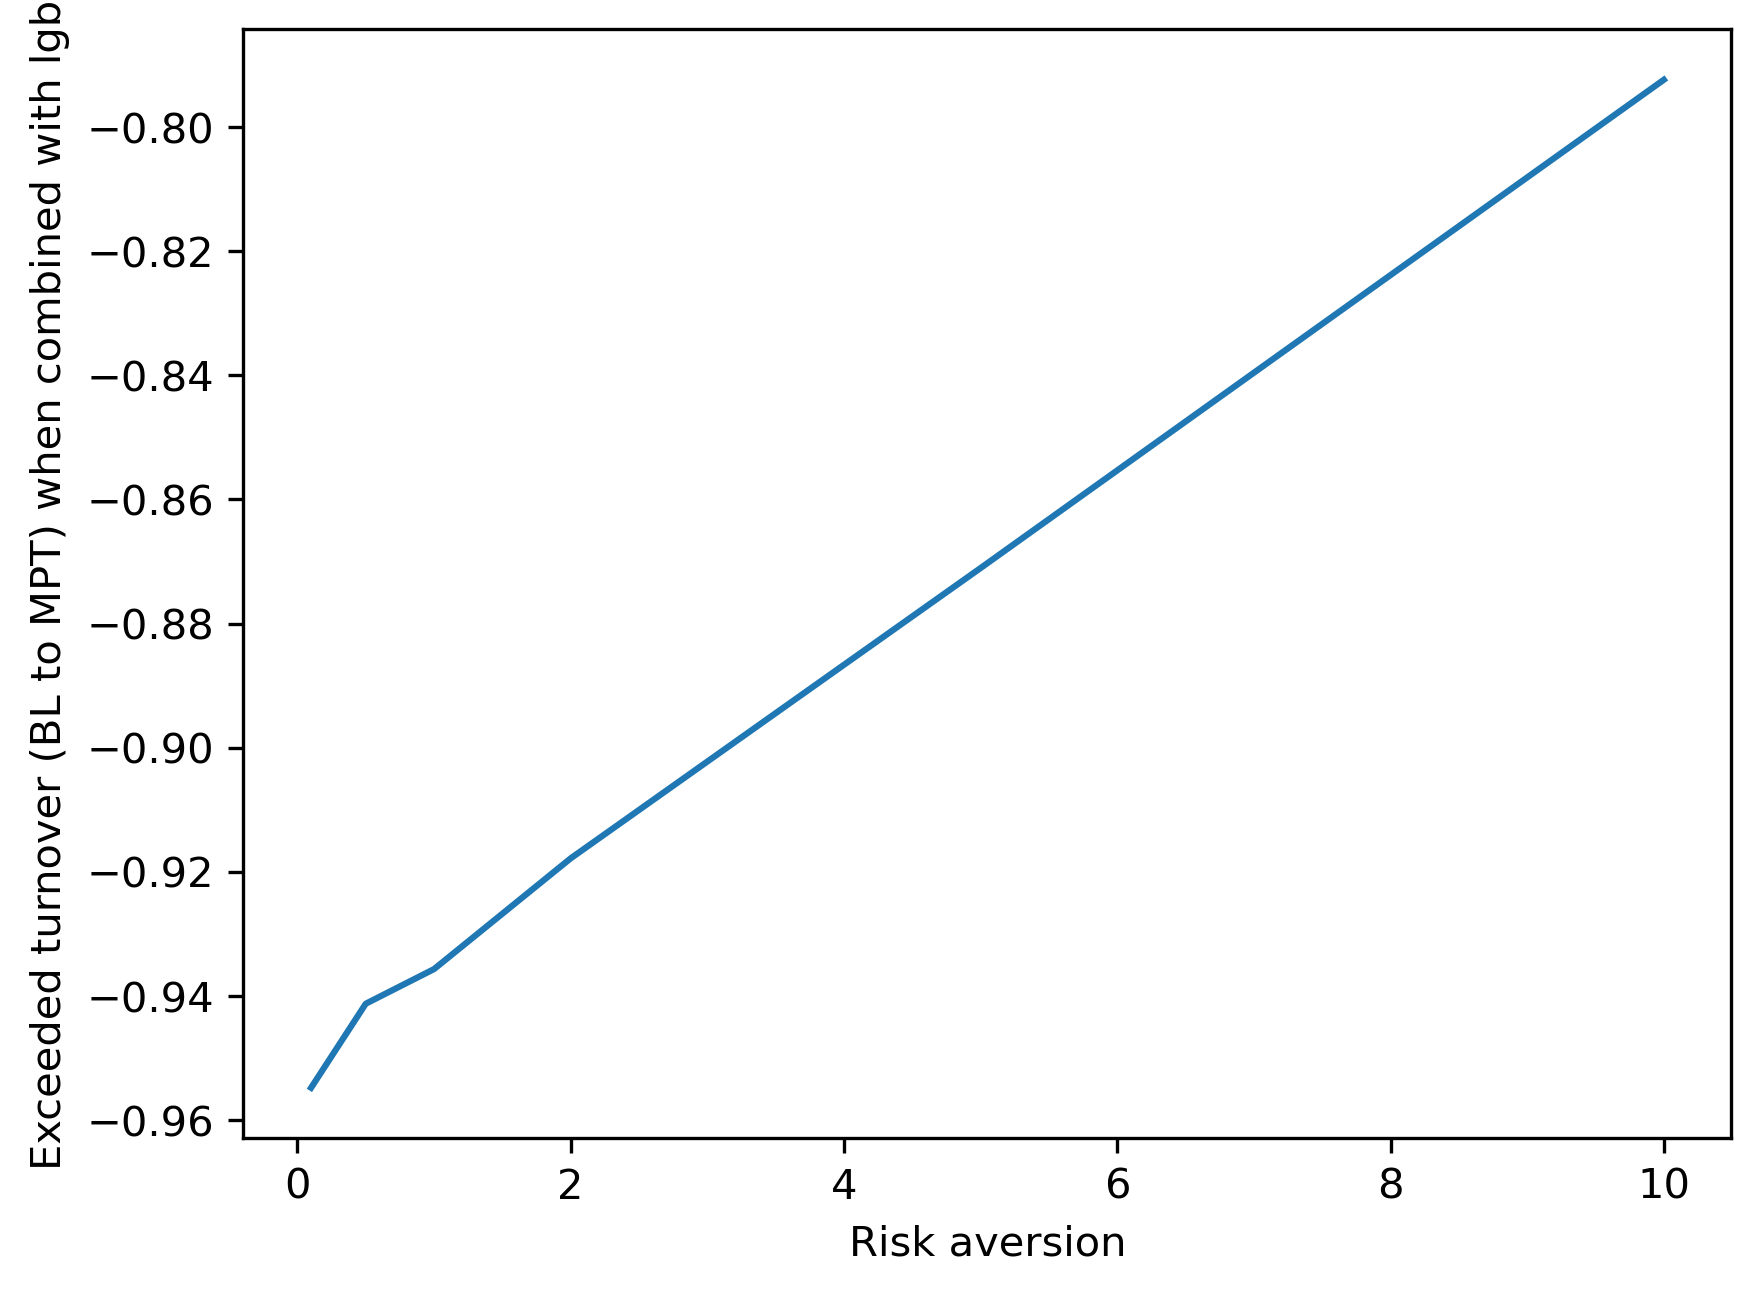

In [41]:
plt.figure(dpi = 300)
plt.plot([0.1, 0.5, 1, 2, 5, 10], exceeded_turnover_lgb)
plt.xlabel("Risk aversion")
plt.ylabel("Exceeded turnover (BL to MPT) when combined with lgb")

Text(0, 0.5, 'Exceeded turnover (BL to MPT) when combined with xgb')

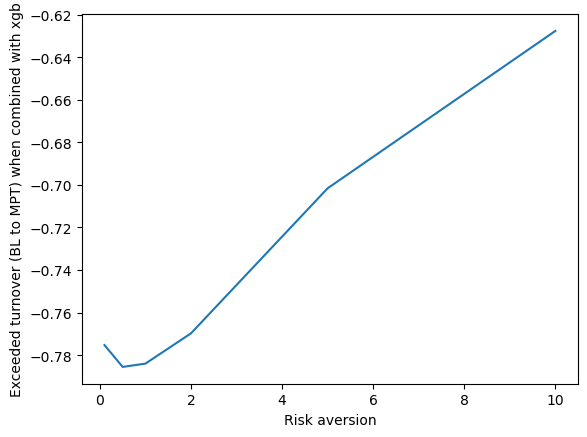

In [42]:
plt.plot([0.1, 0.5, 1, 2, 5, 10], exceeded_turnover_xgb)
plt.xlabel("Risk aversion")
plt.ylabel("Exceeded turnover (BL to MPT) when combined with xgb")

Text(0, 0.5, 'Exceeded return (BL to MPT) when combined with lgb')

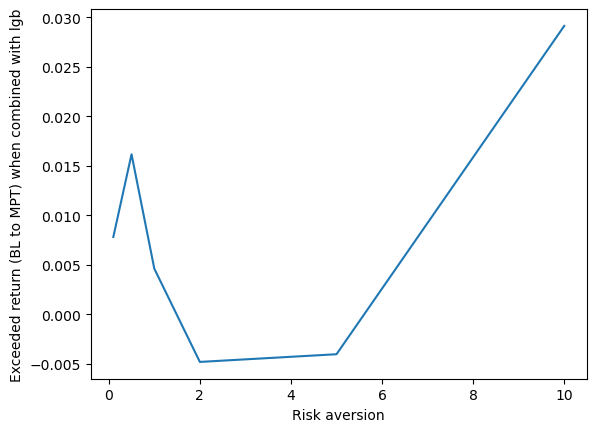

In [43]:
plt.plot([0.1, 0.5, 1, 2, 5, 10], exceeded_return_lgb)
plt.xlabel("Risk aversion")
plt.ylabel("Exceeded return (BL to MPT) when combined with lgb")

Text(0, 0.5, 'Exceeded return (BL to MPT) when combined with xgb')

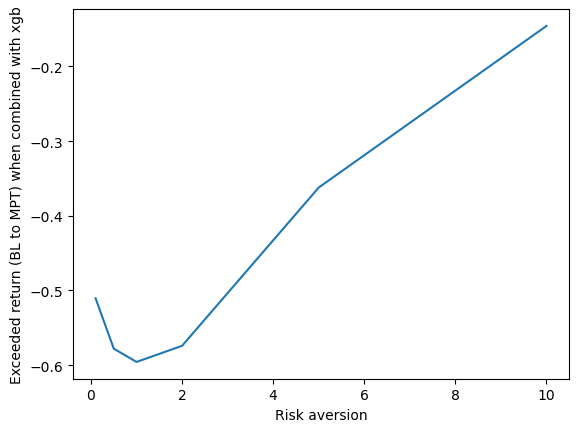

In [44]:
plt.plot([0.1, 0.5, 1, 2, 5, 10], exceeded_return_xgb)
plt.xlabel("Risk aversion")
plt.ylabel("Exceeded return (BL to MPT) when combined with xgb")

Text(0, 0.5, 'Exceeded sharpe (BL to MPT) when combined with lgb')

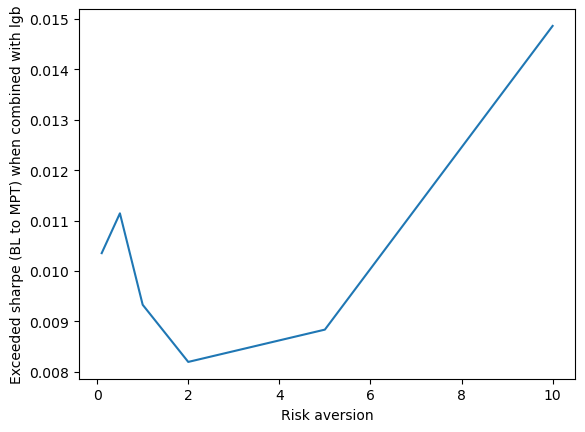

In [45]:
plt.plot([0.1, 0.5, 1, 2, 5, 10], exceeded_sharpe_lgb)
plt.xlabel("Risk aversion")
plt.ylabel("Exceeded sharpe (BL to MPT) when combined with lgb")

Text(0, 0.5, 'Exceeded sharpe (BL to MPT) when combined with xgb')

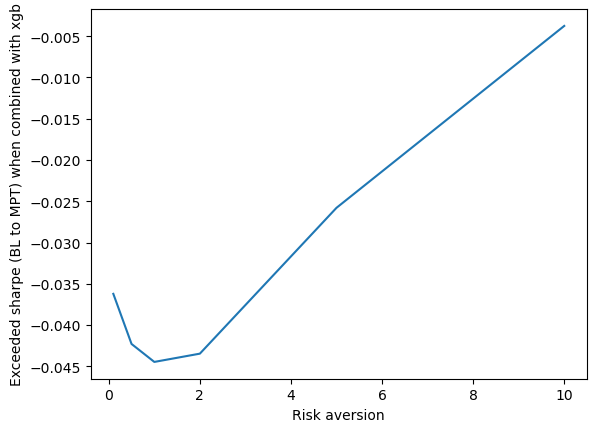

In [46]:
plt.plot([0.1, 0.5, 1, 2, 5, 10], exceeded_sharpe_xgb)
plt.xlabel("Risk aversion")
plt.ylabel("Exceeded sharpe (BL to MPT) when combined with xgb")